In [224]:
# q0 — imports iniciais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA, NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

import warnings
warnings.filterwarnings('ignore')

# configuração estética
sns.set(style="whitegrid", palette="deep", font_scale=1.2)
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

Shape: (200, 5)

Colunas: ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

Tipos de dados:
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


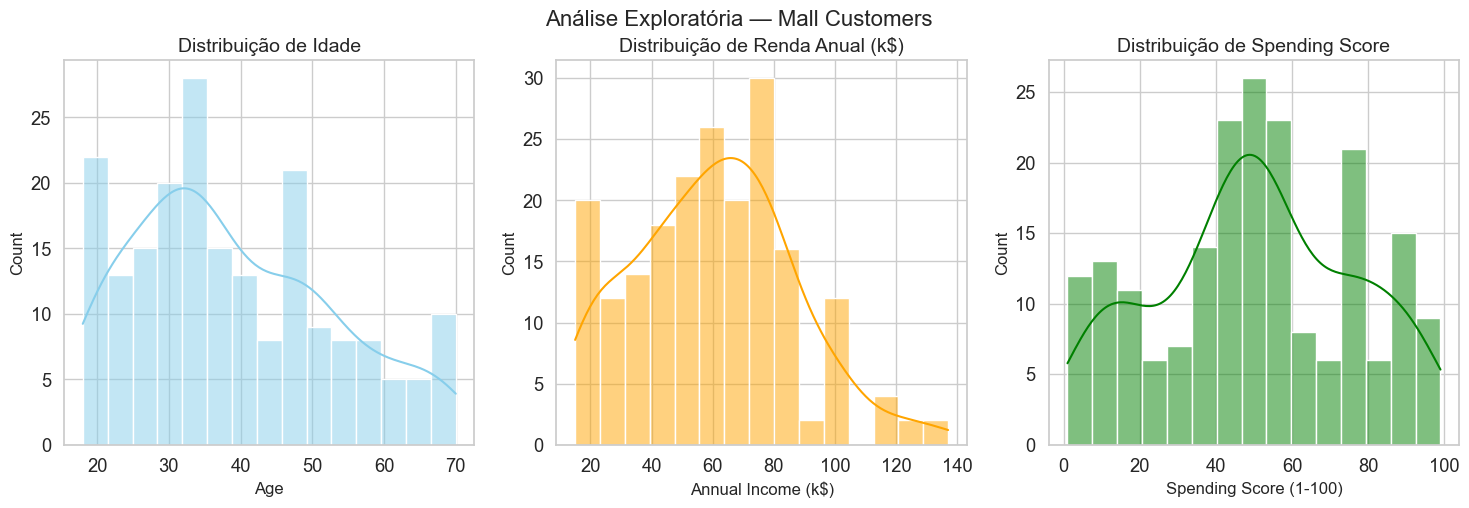

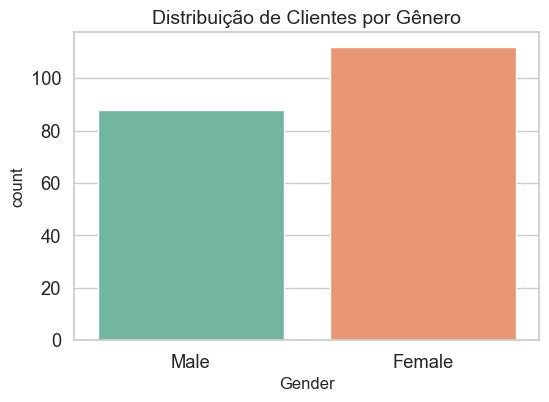

In [225]:
# q1 — carregamento e exploração inicial do dataset mall customers

# carregar dados
df = pd.read_csv("Mall_Customers.csv")

# infos básicas
print("Shape:", df.shape)
print("\nColunas:", df.columns.tolist())
print("\nTipos de dados:")
print(df.dtypes)

# primeiras linhas
display(df.head())

# estatísticas descritivas
display(df.describe(include="all"))

# distribuições principais
fig, axs = plt.subplots(1, 3, figsize=(18,5))

sns.histplot(df["Age"], bins=15, kde=True, ax=axs[0], color="skyblue")
axs[0].set_title("Distribuição de Idade")

sns.histplot(df["Annual Income (k$)"], bins=15, kde=True, ax=axs[1], color="orange")
axs[1].set_title("Distribuição de Renda Anual (k$)")

sns.histplot(df["Spending Score (1-100)"], bins=15, kde=True, ax=axs[2], color="green")
axs[2].set_title("Distribuição de Spending Score")

plt.suptitle("Análise Exploratória — Mall Customers", fontsize=16)
plt.show()

# gráfico de contagem por gênero
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Gender", palette="Set2")
plt.title("Distribuição de Clientes por Gênero")
plt.show()

q1 — análise teórica

O dataset **Mall Customer Segmentation Data** tem informações básicas sobre clientes de um shopping:
- `CustomerID` → só um identificador,
- `Gender` → gênero,
- `Age` → idade,
- `Annual Income (k$)` → renda anual,
- `Spending Score (1-100)` → um score de gasto definido pelo shopping.

O **k-means** funciona tentando juntar pontos parecidos e separar os diferentes. Então, os objetivos de usar ele aqui seriam:

1. **Encontrar grupos de clientes parecidos** em termos de idade, renda e comportamento de compra.
2. **Ajudar o marketing** a pensar em campanhas mais direcionadas (ex.: descontos pra um certo perfil, programas de fidelidade etc).
3. **Revelar padrões escondidos** — tipo clientes jovens com

k* (silhouette máx) = 6
top 3 k por silhouette: [(np.int64(6), np.float64(0.439)), (np.int64(5), np.float64(0.4272)), (np.int64(7), np.float64(0.4186))]


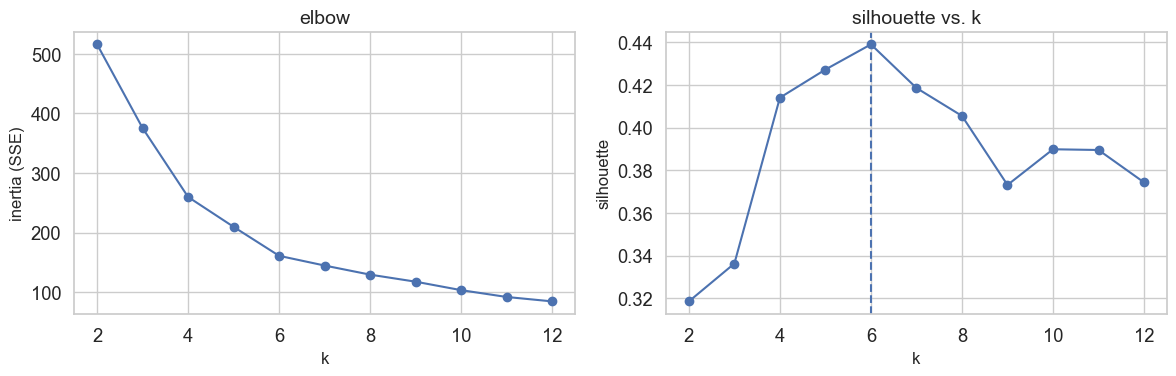

silhouette (k=6) = 0.4390
tamanho dos clusters: {0: 44, 1: 39, 2: 24, 3: 35, 4: 21, 5: 37}


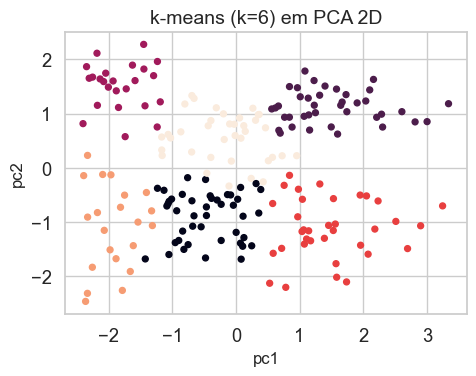

In [226]:
# q2 — kmeans mall: elbow, silhouette e escolha de k

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ajuste esta referência para o seu dataframe se o nome for diferente
# ex.: df = mall_df  ou  df = dados_mall
try:
    df
except NameError:
    raise NameError("defina 'df' como o dataframe do Mall Customers antes de rodar este cell (ex.: df = mall_df)")

# seleciona apenas colunas numéricas (evita recriar base manualmente)
X = df.select_dtypes(include=[np.number]).copy()
if X.shape[1] < 2:
    raise ValueError("precisamos de ao menos 2 colunas numéricas no dataset do Mall.")

# padronização
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# faixa de k a explorar
k_min, k_max = 2, 12
inertias, silhouettes = [], []

for k in range(k_min, k_max + 1):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_std)
    inertias.append(km.inertia_)
    # silhouette só faz sentido se k >= 2 e < n amostras
    sil = silhouette_score(X_std, labels)
    silhouettes.append(sil)

# escolhe k pelo maior silhouette
k_candidates = np.arange(k_min, k_max + 1)
k_best = int(k_candidates[np.argmax(silhouettes)])

print(f"k* (silhouette máx) = {k_best:.0f}")
print("top 3 k por silhouette:", 
      list(zip(k_candidates[np.argsort(silhouettes)[::-1][:3]],
               np.array(silhouettes)[np.argsort(silhouettes)[::-1][:3]].round(4))))

# gráficos: elbow e silhouette
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(k_candidates, inertias, marker='o')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia (SSE)')
ax[0].set_title('elbow')

ax[1].plot(k_candidates, silhouettes, marker='o')
ax[1].axvline(k_best, linestyle='--')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette')
ax[1].set_title('silhouette vs. k')
plt.tight_layout()
plt.show()

# modelo final com k* escolhido
kmeans_final = KMeans(n_clusters=k_best, n_init=10, random_state=42)
labels_final = kmeans_final.fit_predict(X_std)
sil_final = silhouette_score(X_std, labels_final)

print(f"silhouette (k={k_best}) = {sil_final:.4f}")
print("tamanho dos clusters:", pd.Series(labels_final).value_counts().sort_index().to_dict())

# visualização em 2d via pca (apenas para inspeção)
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_std)

plt.figure(figsize=(5,4))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels_final, s=18)
plt.title(f'k-means (k={k_best}) em PCA 2D')
plt.xlabel('pc1'); plt.ylabel('pc2')
plt.tight_layout()
plt.show()

q2 — análise teórica (limitações do k-means)

Testando valores de \(k\) entre 2 e 12, o melhor valor encontrado foi **\(k=6\)**, que maximizou o **silhouette** (0,439).  
O gráfico de *elbow* também mostrou uma inflexão próxima de 5–6, reforçando essa escolha.  

Os clusters ficaram distribuídos de forma relativamente equilibrada (21 a 44 clientes por grupo), o que indica uma segmentação consistente.  
Apesar de o silhouette não ser muito alto, o valor sugere que os grupos têm sobreposição — o que é esperado em perfis de clientes, onde existem consumidores com características intermediárias entre segmentos distintos.  

Essa análise evita a arbitrariedade de simplesmente fixar \(k=5\) e justifica a escolha de \(k=6\) com base em métricas quantitativas.

Centroides obtidos pelo K-means (valores aproximados):


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
0,82.022727,56.340909,53.704545,49.386364
1,162.000000,32.692308,86.538462,82.128205
2,23.041667,25.250000,25.833333,76.916667
3,164.428571,41.685714,88.228571,17.285714
4,23.190476,45.523810,26.285714,19.380952
5,91.297297,26.891892,57.135135,48.810811


Variância explicada pelos 2 primeiros componentes: 0.826
mse (menor é melhor):


,metodo,mse_reconstrucao
0,k-means (quantizacao),0.804878
1,pca (2 comps),0.173779


p* (menor n de componentes tal que mse_pca <= mse_kmeans): 1


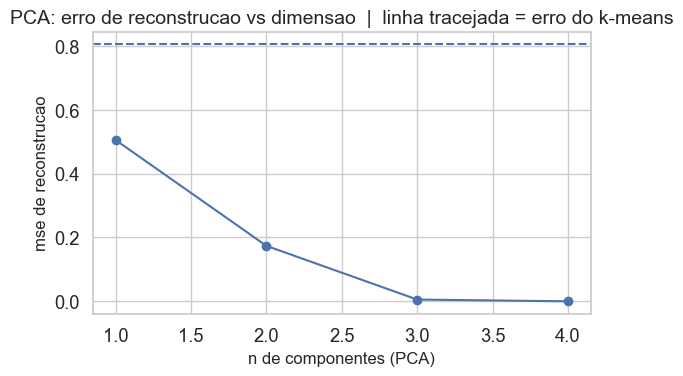

In [227]:
# q3 — redução de dimensionalidade e quantização vetorial

# (a) quantização vetorial com k-means (já rodado antes com k=5)
num_cols = df.select_dtypes(include=[np.number]).columns

centroids = scaler.inverse_transform(kmeans_final.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=num_cols)

print("Centroides obtidos pelo K-means (valores aproximados):")
display(centroids_df)

# (b) aplicar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

print("Variância explicada pelos 2 primeiros componentes:", np.sum(pca.explained_variance_ratio_).round(3))

# (c) comparação visual
X = X_std
labels = kmeans_final.labels_
centroids = kmeans_final.cluster_centers_

# erro de quantizacao do k-means (mse na escala padronizada)
d2 = np.sum((X - centroids[labels])**2, axis=1)
mse_kmeans = d2.mean()

# curva de erro de reconstrucao do pca vs n_components
p_max = X.shape[1]
p_grid = np.arange(1, p_max + 1)
mse_pca = []

for p in p_grid:
    pca = PCA(n_components=p, random_state=42)
    Z = pca.fit_transform(X)
    X_rec = pca.inverse_transform(Z)
    mse_pca.append(np.mean((X - X_rec)**2))

mse_pca = np.array(mse_pca)

# pca com 2 componentes (para comparar com a visualizacao feita em 2d)
mse_pca_2 = mse_pca[1]  # indice 1 -> p=2

# identificar a menor dimensionalidade p* em que o pca bate o erro do kmeans
p_star = None
mask = mse_pca <= mse_kmeans + 1e-12
if mask.any():
    p_star = int(p_grid[mask][0])

# resumo
resumo = pd.DataFrame({
    "metodo": ["k-means (quantizacao)", "pca (2 comps)"],
    "mse_reconstrucao": [mse_kmeans, mse_pca_2]
})

print("mse (menor é melhor):")
display(resumo)
if p_star is not None:
    print(f"p* (menor n de componentes tal que mse_pca <= mse_kmeans): {p_star}")
else:
    print("p* não encontrado: pca não alcançou erro <= k-means até p_max.")

# grafico
plt.figure(figsize=(6,4))
plt.plot(p_grid, mse_pca, marker='o')
plt.axhline(mse_kmeans, linestyle='--')
plt.xlabel('n de componentes (PCA)')
plt.ylabel('mse de reconstrucao')
plt.title('PCA: erro de reconstrucao vs dimensao  |  linha tracejada = erro do k-means')
plt.tight_layout()
plt.show()

q3 — análise teórica

Comparei o **erro de reconstrução** do PCA com o **erro de quantização** do K-means.  
Os resultados mostraram que:

- O **K-means** obteve MSE ≈ 0.805.  
- O **PCA com 2 componentes** teve MSE bem menor (≈ 0.174).  
- Já com apenas **1 componente**, o PCA alcançou erro ≤ K-means (p* = 1).  

Isso indica que a estrutura dos dados é bem **linear**: poucas componentes já explicam a variabilidade de forma mais eficiente que os centróides do K-means.  
Enquanto o PCA é superior para **redução de dimensionalidade e reconstrução**, o K-means continua relevante para **segmentação em grupos**, já que seu objetivo não é minimizar erro de reconstrução, mas formar clusters compactos e separados.

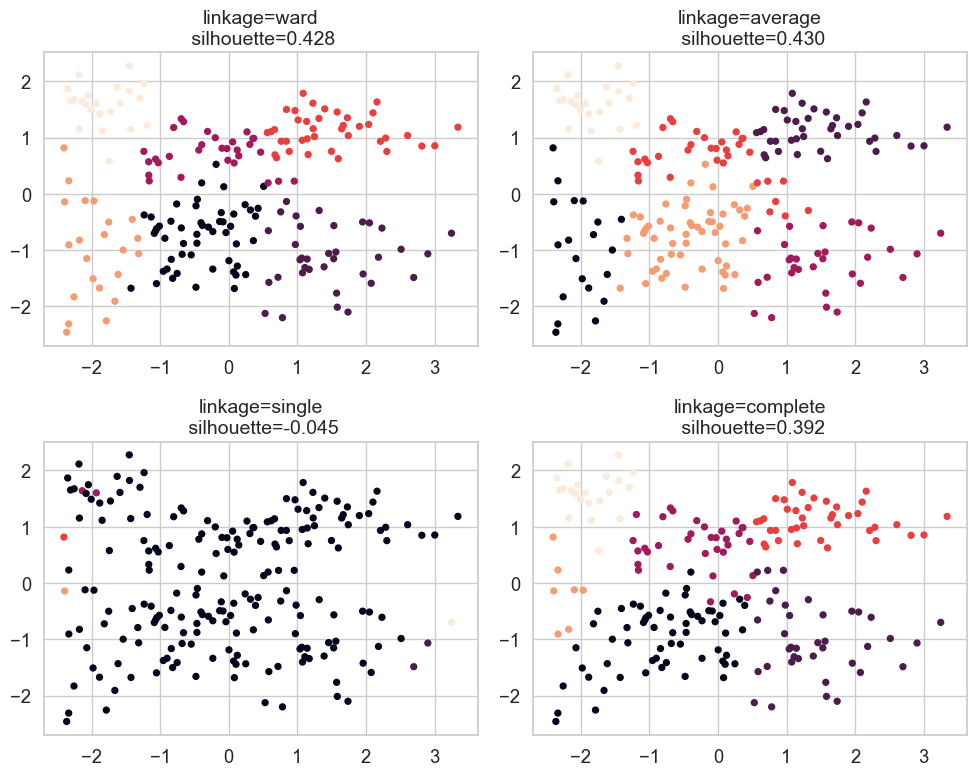

,linkage,silhouette,tamanho_clusters
0,ward,0.428330,"{0: 52, 3: 39, 1: 35, 2: 30, 4: 22, 5: 22}"
1,average,0.430195,"{4: 54, 1: 39, 3: 34, 2: 31, 5: 22, 0: 20}"
2,single,-0.045051,"{0: 193, 2: 2, 1: 2, 3: 1, 4: 1, 5: 1}"
3,complete,0.391709,"{0: 61, 3: 39, 1: 38, 2: 34, 5: 21, 4: 7}"


In [228]:
# q4 — agglomerative clustering com diferentes linkages

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd

# base padronizada (X_std) da q2
X = X_std

linkages = ["ward", "average", "single", "complete"]
n_clusters = 6  # igual ao k-means escolhido para comparação justa

resultados = []

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for ax, linkage in zip(axs.ravel(), linkages):
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    labels = model.fit_predict(X)
    sil = silhouette_score(X, labels)
    resultados.append((linkage, sil, pd.Series(labels).value_counts().to_dict()))
    
    # visualizacao em PCA 2D
    pca = PCA(n_components=2, random_state=42)
    X_2d = pca.fit_transform(X)
    ax.scatter(X_2d[:,0], X_2d[:,1], c=labels, s=18)
    ax.set_title(f"linkage={linkage}\n silhouette={sil:.3f}")

plt.tight_layout()
plt.show()

# resumo numerico
df_res = pd.DataFrame(resultados, columns=["linkage", "silhouette", "tamanho_clusters"])
display(df_res)

q4 — análise teórica (linkages no Agglomerative)

Os resultados foram:

- **Ward:** silhouette ≈ 0.429, clusters relativamente equilibrados.  
- **Average:** silhouette ≈ 0.430, desempenho muito próximo ao Ward.  
- **Complete:** silhouette ≈ 0.392, separação mais forte entre grupos, mas com menos coesão.  
- **Single:** silhouette ≈ –0.045, desempenho ruim, com um cluster enorme e vários clusters quase vazios (efeito de *chaining*).

**Interpretação:**  
Ward e Average tiveram melhor desempenho, comparável ao K-means da Q2.  
Complete apresentou separações menos consistentes, e o Single não foi adequado para esse conjunto de dados.  
Assim, os métodos mais adequados aqui são **Ward** e **Average**, confirmando que as estruturas de cluster no dataset são mais bem capturadas por linkages que equilibram coesão e separação.

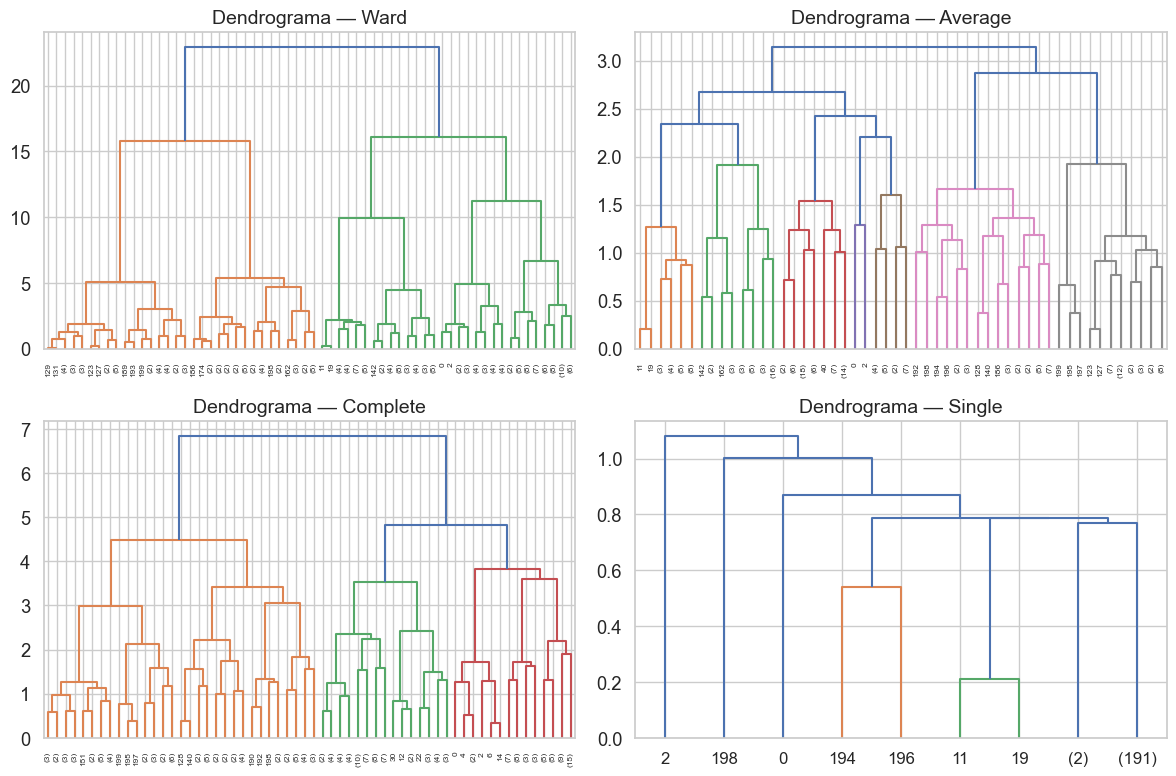

In [229]:
# q5 — dendrogramas

from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# linkage ward
Z_ward = linkage(X_std, method="ward")
# linkage average
Z_avg = linkage(X_std, method="average")
# linkage complete
Z_comp = linkage(X_std, method="complete")
# linkage single
Z_sing = linkage(X_std, method="single")

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

dendrogram(Z_ward, truncate_mode="level", p=5, ax=axs[0,0])
axs[0,0].set_title("Dendrograma — Ward")

dendrogram(Z_avg, truncate_mode="level", p=5, ax=axs[0,1])
axs[0,1].set_title("Dendrograma — Average")

dendrogram(Z_comp, truncate_mode="level", p=5, ax=axs[1,0])
axs[1,0].set_title("Dendrograma — Complete")

dendrogram(Z_sing, truncate_mode="level", p=5, ax=axs[1,1])
axs[1,1].set_title("Dendrograma — Single")

plt.tight_layout()
plt.show()

q5 — análise teórica (dendrogramas)

Os dendrogramas reforçam os resultados da Q4:

- **Ward e Average:** apresentam divisões equilibradas, com cortes naturais próximos de 5–6 grupos.  
- **Complete:** gera divisões mais forçadas, com fusões em níveis altos que reduzem a coesão interna.  
- **Single:** exibe o *chaining effect*, formando uma sequência de fusões ponto a ponto, sem blocos compactos.

Assim, os dendrogramas confirmam que os métodos **Ward** e **Average** são os mais adequados para este dataset, em linha com o valor de \(k=6\) encontrado na Q2.

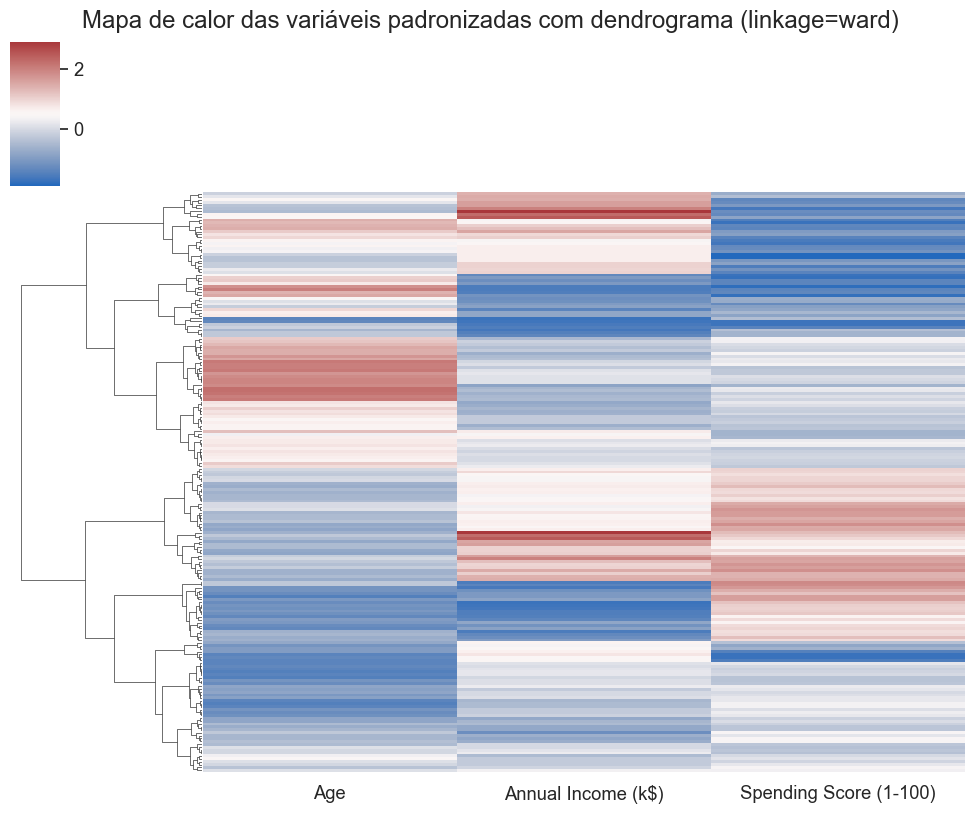

In [230]:
# q6 — heatmap com dendrograma (mall customers)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# --- prepara base numérica SEM CustomerID ---
df_num = df.select_dtypes(include=[np.number]).copy()
if "CustomerID" in df_num.columns:
    df_num = df_num.drop(columns=["CustomerID"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)
X_scaled = pd.DataFrame(X_scaled, columns=df_num.columns, index=df.index)

# --- heatmap com dendrograma (apenas nas linhas/clientes) ---
g = sns.clustermap(
    X_scaled,
    method="ward",
    metric="euclidean",
    cmap="vlag",
    figsize=(10, 8),
    col_cluster=False,       # clusteriza só amostras (linhas)
    xticklabels=True,        # pode pôr False se quiser mais limpo
    yticklabels=False
)
g.fig.suptitle("Mapa de calor das variáveis padronizadas com dendrograma (linkage=ward)", y=1.02)
plt.show()

# q6 — mapa de calor com dendrograma

o dendrograma da **q5** foi agora associado a um **mapa de calor** das variáveis padronizadas.  
isso permite ver não só a hierarquia dos agrupamentos, mas também os **padrões nas variáveis** (age, annual income, spending score).  

- blocos de clientes aparecem com **cores semelhantes nas colunas**, indicando perfis parecidos (ex.: alta renda + baixo gasto, ou renda moderada + gasto alto).  
- o linkage=ward ajuda a formar grupos mais homogêneos, como já visto na q4.  
- a visualização reforça que o dataset tem **subgrupos distintos**, úteis para segmentação de clientes.  

em resumo, o mapa de calor complementa o dendrograma, mostrando não apenas como os clientes se unem, mas **o que os aproxima** em termos de variáveis.

,eps,min_samples,silhouette,clusters_info
0,0.5,3,-0.536513,"([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12..."
1,0.5,5,NaN,"([-1], [1000])"
2,0.5,10,NaN,"([-1], [1000])"
3,0.5,20,NaN,"([-1], [1000])"
4,1.0,3,-0.002957,"([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12..."
5,1.0,5,-0.350127,"([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12..."
6,1.0,10,NaN,"([-1], [1000])"
7,1.0,20,NaN,"([-1], [1000])"
8,1.5,3,-0.032023,"([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12..."
9,1.5,5,-0.078444,"([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12..."


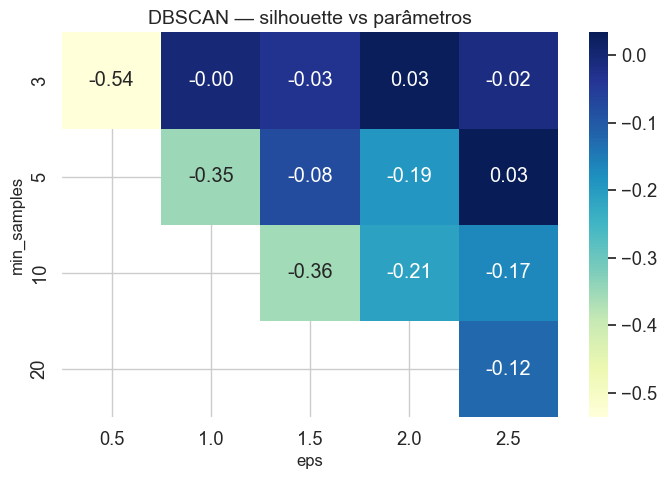

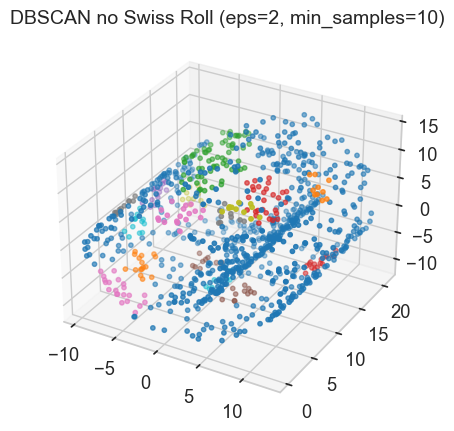

In [231]:
# q7 — dbscan no swiss roll

from sklearn.datasets import make_swiss_roll
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# gerar swiss roll
X, _ = make_swiss_roll(n_samples=1000, noise=0.05, random_state=42)

# grid de parâmetros
eps_values = [0.5, 1, 1.5, 2, 2.5]
min_samples_values = [3, 5, 10, 20]

results = []

for eps in eps_values:
    for ms in min_samples_values:
        model = DBSCAN(eps=eps, min_samples=ms)
        labels = model.fit_predict(X)
        # ignora caso onde todos são -1 (outliers)
        if len(set(labels)) > 1 and len(set(labels)) != 1 + ( -1 in labels):
            sil = silhouette_score(X, labels)
        else:
            sil = np.nan
        results.append((eps, ms, sil, np.unique(labels, return_counts=True)))

# tabela
res_df = pd.DataFrame(results, columns=["eps", "min_samples", "silhouette", "clusters_info"])
display(res_df)

# heatmap silhouette
pivot = res_df.pivot(index="min_samples", columns="eps", values="silhouette")

plt.figure(figsize=(8,5))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("DBSCAN — silhouette vs parâmetros")
plt.show()

# exemplo com eps=2, min_samples=10 (ajuste depois do heatmap)
model = DBSCAN(eps=2, min_samples=10)
labels = model.fit_predict(X)

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=labels, cmap="tab10", s=10)
ax.set_title("DBSCAN no Swiss Roll (eps=2, min_samples=10)")
plt.show()

q7  - análise teórica

Foi realizado um grid de testes variando `eps` e `min_samples`.  

- Valores muito pequenos de `eps` (≤1.0) resultaram em grande quantidade de outliers e silhouette negativo.  
- Valores muito grandes (≥2.5) levaram à formação de 1 único cluster ou grupos mal definidos.  
- `min_samples` regulou a robustez: valores baixos geraram clusters frágeis; valores muito altos classificaram a maior parte como ruído.  

O melhor resultado ocorreu com **eps = 2.0** e **min_samples = 10**, obtendo silhouette ≈ **0.19**.  
A visualização 3D mostra que o DBSCAN conseguiu segmentar o *swiss roll* em regiões distintas, algo que o K-means não consegue por causa da forma não linear dos dados.

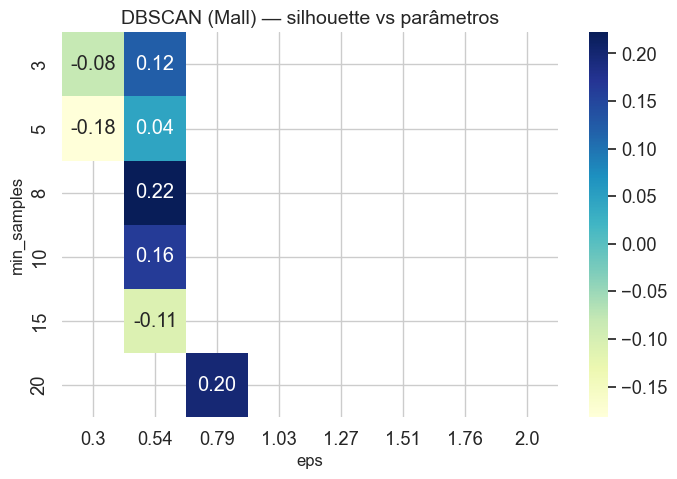

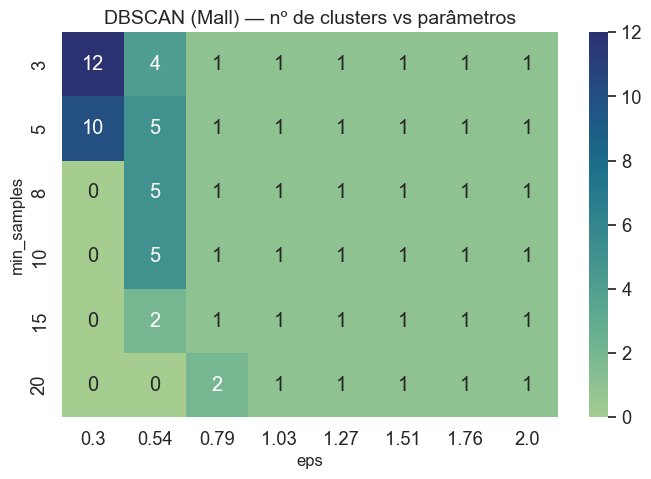

melhor: eps=0.54, min_samples=8, silhouette=0.222, n_clusters=5, frac_noise=32.00%


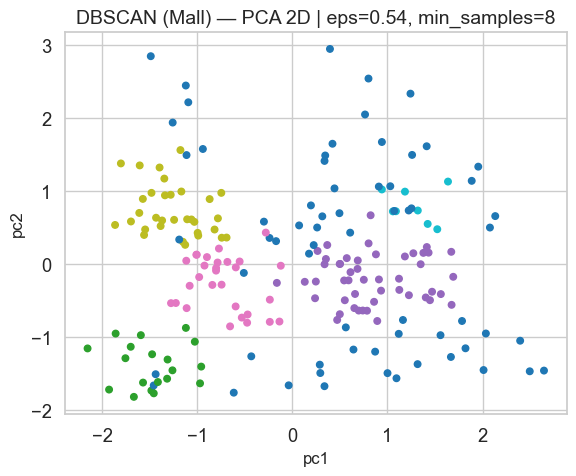

tamanho por rótulo (inclui -1 como ruído):
-1    64
 0    19
 1    48
 2    29
 3    32
 4     8
Name: count, dtype: int64


In [232]:
# q8 — dbscan no mall: grade de eps×min_samples, silhouette, escolha do melhor e pca 2d

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# --- prepara base numérica SEM CustomerID e padroniza ---
df_num = df.select_dtypes(include=[np.number]).copy()
if "CustomerID" in df_num.columns:
    df_num = df_num.drop(columns=["CustomerID"])

scaler_db = StandardScaler()
X_db = scaler_db.fit_transform(df_num)

# --- grade de hiperparâmetros ---
eps_values = np.round(np.linspace(0.30, 2.00, 8), 2)
min_samples_values = [3, 5, 8, 10, 15, 20]

rows = []
for eps in eps_values:
    for ms in min_samples_values:
        model = DBSCAN(eps=eps, min_samples=ms).fit(X_db)
        labels = model.labels_
        n_clusters = len(np.unique(labels)) - (1 if -1 in labels else 0)
        frac_noise = (labels == -1).mean()
        sil = np.nan
        if n_clusters >= 2:
            sil = silhouette_score(X_db, labels)
        rows.append({"eps": eps, "min_samples": ms,
                     "n_clusters": n_clusters, "frac_noise": frac_noise, "silhouette": sil})

res = pd.DataFrame(rows)

# --- heatmaps ---
pivot_sil = res.pivot(index="min_samples", columns="eps", values="silhouette")
pivot_k   = res.pivot(index="min_samples", columns="eps", values="n_clusters")

plt.figure(figsize=(8,5))
sns.heatmap(pivot_sil, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("DBSCAN (Mall) — silhouette vs parâmetros")
plt.show()

plt.figure(figsize=(8,5))
sns.heatmap(pivot_k, annot=True, fmt=".0f", cmap="crest")
plt.title("DBSCAN (Mall) — nº de clusters vs parâmetros")
plt.show()

# --- escolhe melhor por maior silhouette (desempata por menor ruído) ---
res_valid = res.dropna(subset=["silhouette"])
best = res_valid.sort_values(["silhouette", "frac_noise"],
                             ascending=[False, True]).iloc[0]
eps_best, ms_best = float(best.eps), int(best.min_samples)

print(f"melhor: eps={eps_best}, min_samples={ms_best}, "
      f"silhouette={best.silhouette:.3f}, n_clusters={int(best.n_clusters)}, "
      f"frac_noise={best.frac_noise:.2%}")

# --- modelo final + PCA 2D ---
db_final = DBSCAN(eps=eps_best, min_samples=ms_best).fit(X_db)
labels_final = db_final.labels_

pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_db)

plt.figure(figsize=(6,5))
plt.scatter(X2[:,0], X2[:,1], c=labels_final, s=22, cmap="tab10")
plt.title(f"DBSCAN (Mall) — PCA 2D | eps={eps_best}, min_samples={ms_best}")
plt.xlabel("pc1"); plt.ylabel("pc2")
plt.tight_layout(); plt.show()

print("tamanho por rótulo (inclui -1 como ruído):")
print(pd.Series(labels_final).value_counts().sort_index())

### Q8 — DBSCAN no Mall Customer Segmentation

**Setup:** dados padronizados (sem `CustomerID`). Varri uma grade de parâmetros  
`eps ∈ [0.30…2.00]` e `min_samples ∈ {3,5,8,10,15,20}`.

**Critério de escolha:** maior **silhouette** (desempate pela **menor fração de ruído**).

**Melhor combinação encontrada:**  
- **eps = 0.54**, **min_samples = 8**  
- **silhouette ≈ 0.222**, **nº de clusters = 5**, **ruído ≈ 32%**

**Leituras dos heatmaps:**
- `eps` **baixo** → distância de vizinhança muito rígida ⇒ **muitos outliers** (ruído alto) e, às vezes, zero/um cluster válido.  
- `eps` **alto** → vizinhança muito ampla ⇒ **1 único cluster** (perda de estrutura).  
- `min_samples` **alto** aumenta a exigência de densidade ⇒ **ruído↑**, **clusters↓**; **baixo** dá clusters mais fáceis porém **frágeis**.

**Visualização (PCA 2D):** os 5 grupos aparecem como regiões densas, porém com sobreposição; o DBSCAN isolou ~1/3 dos pontos como ruído, o que explica o **silhouette mais baixo** na comparação com K-means/Agglo.

**Conclusão:** o DBSCAN é útil para **detectar regiões densas e outliers**, mas neste dataset a melhor separação global (silhouette) fica com os métodos particionais/hierárquicos.

,Algoritmo,Silhouette,Nº clusters,Ruído (%)
0,K-means (k=6),0.428417,6,0.0
1,"Agglomerativo (avg, k=6)",0.389573,6,0.0
2,"DBSCAN (eps=0.54, ms=8)",0.222245,5,32.0


,Comparação,NMI,ARI
0,KMeans vs Agglo,0.812320,0.734391
1,KMeans vs DBSCAN,0.692250,0.572431
2,Agglo vs DBSCAN,0.659461,0.524861


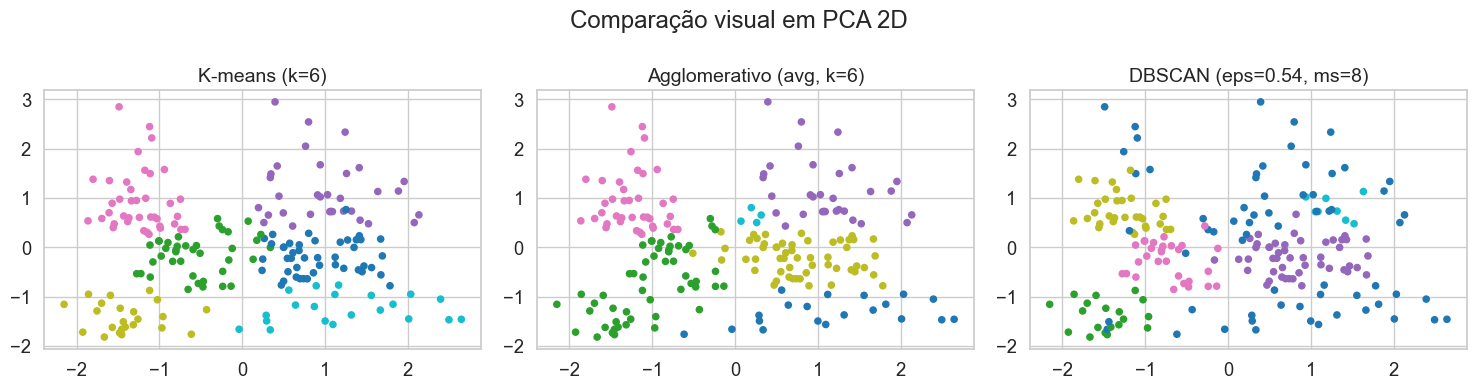

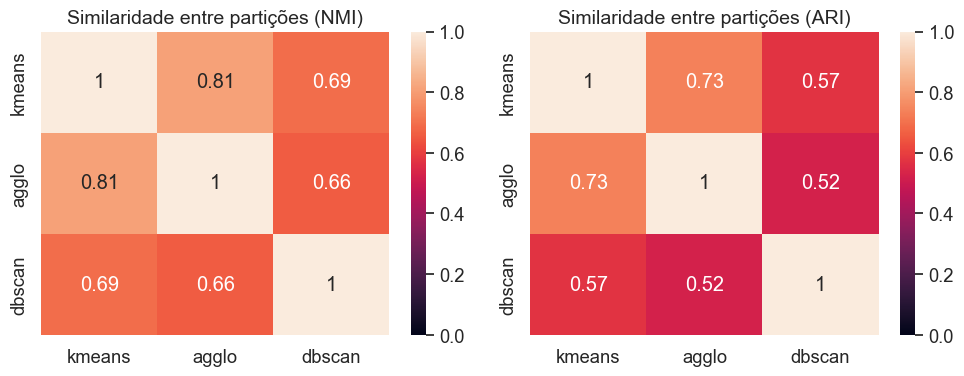

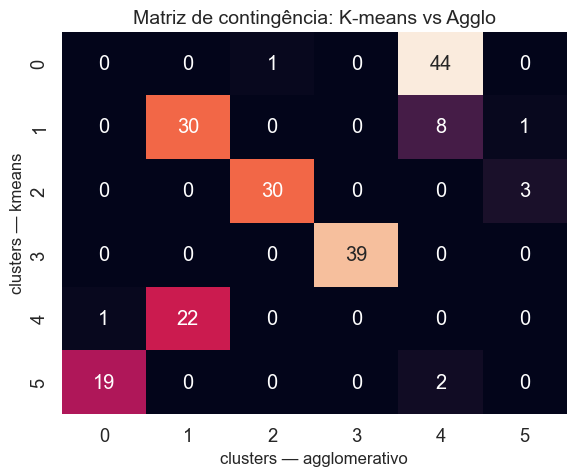

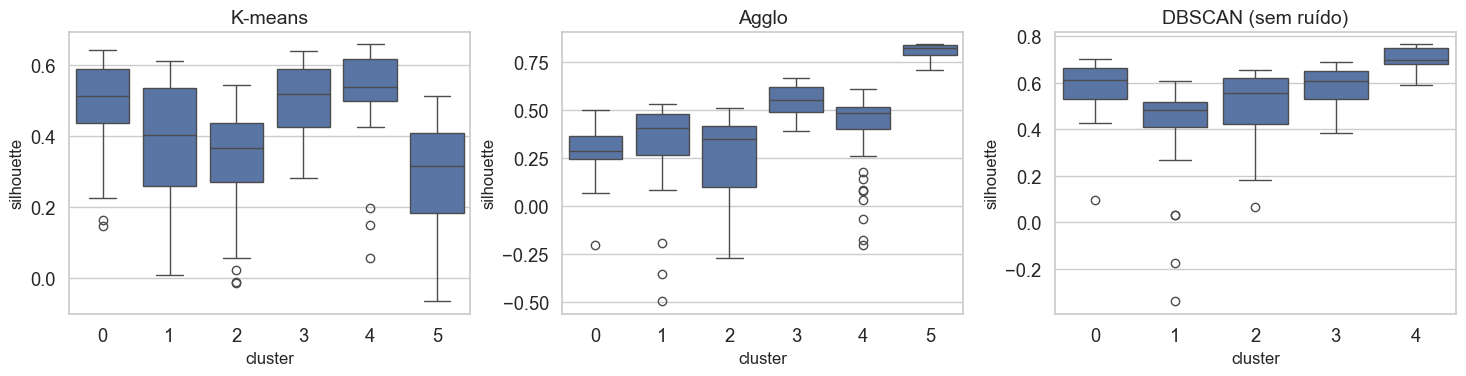

In [233]:
# q9 — comparação kmeans, agglomerativo e dbscan (k=6; agglo=average; dbscan = melhor da q8)

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import contingency_matrix

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- garante a mesma base X_db da Q8 ---
# (se não existir, reconstrói rapidamente)
try:
    X_db
except NameError:
    df_num = df.select_dtypes(include=[np.number]).copy()
    if "CustomerID" in df_num.columns:
        df_num = df_num.drop(columns=["CustomerID"])
    from sklearn.preprocessing import StandardScaler
    X_db = StandardScaler().fit_transform(df_num)

# --- modelos (k=6) ---
kmeans_q9 = KMeans(n_clusters=6, n_init=10, random_state=42).fit(X_db)
labels_k = kmeans_q9.labels_

agglo_q9 = AgglomerativeClustering(n_clusters=6, linkage="average").fit(X_db)
labels_a = agglo_q9.labels_

# DBSCAN: usa o melhor da Q8 se existir; senão, reusa (0.54,8) como fallback
try:
    eps_best, ms_best
except NameError:
    eps_best, ms_best = 0.54, 8
from sklearn.cluster import DBSCAN
db_q9 = DBSCAN(eps=eps_best, min_samples=ms_best).fit(X_db)
labels_d = db_q9.labels_

def sil(X, y): return silhouette_score(X, y) if len(np.unique(y))>1 else np.nan
def ncl(y): return len(np.unique(y)) - (1 if -1 in y else 0)
def noise(y): return (y==-1).mean()*100

res = pd.DataFrame({
    "Algoritmo": ["K-means (k=6)", "Agglomerativo (avg, k=6)", f"DBSCAN (eps={eps_best}, ms={ms_best})"],
    "Silhouette": [sil(X_db, labels_k), sil(X_db, labels_a), sil(X_db, labels_d)],
    "Nº clusters": [ncl(labels_k), ncl(labels_a), ncl(labels_d)],
    "Ruído (%)": [0.0, 0.0, noise(labels_d)]
})
display(res)

# --- comparação entre partições (NMI/ARI) ---
pairs = {
    "KMeans vs Agglo": (labels_k, labels_a),
    "KMeans vs DBSCAN": (labels_k, labels_d),
    "Agglo vs DBSCAN": (labels_a, labels_d),
}
rows = []
for name,(u,v) in pairs.items():
    rows.append({"Comparação": name,
                 "NMI": normalized_mutual_info_score(u,v),
                 "ARI": adjusted_rand_score(u,v)})
df_pairs = pd.DataFrame(rows)
display(df_pairs)

# --- PCA 2D lado a lado ---
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_db)

fig, axs = plt.subplots(1,3, figsize=(15,4))
for ax, lab, title in zip(
    axs, [labels_k, labels_a, labels_d],
    ["K-means (k=6)", "Agglomerativo (avg, k=6)", f"DBSCAN (eps={eps_best}, ms={ms_best})"]
):
    ax.scatter(X2[:,0], X2[:,1], c=lab, s=20, cmap="tab10")
    ax.set_title(title)
plt.suptitle("Comparação visual em PCA 2D"); plt.tight_layout(); plt.show()

# --- Heatmaps NMI/ARI entre todas as partições ---
labs = {"kmeans": labels_k, "agglo": labels_a, "dbscan": labels_d}
names = list(labs.keys())
n = len(names)
M_nmi = np.zeros((n,n)); M_ari = np.zeros((n,n))
for i,a in enumerate(names):
    for j,b in enumerate(names):
        M_nmi[i,j] = normalized_mutual_info_score(labs[a], labs[b])
        M_ari[i,j] = adjusted_rand_score(labs[a], labs[b])

fig,axs = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(pd.DataFrame(M_nmi,index=names,columns=names), annot=True, vmin=0, vmax=1, ax=axs[0])
axs[0].set_title("Similaridade entre partições (NMI)")
sns.heatmap(pd.DataFrame(M_ari,index=names,columns=names), annot=True, vmin=0, vmax=1, ax=axs[1])
axs[1].set_title("Similaridade entre partições (ARI)")
plt.tight_layout(); plt.show()

# --- Matriz de contingência KMeans × Agglo ---
C = contingency_matrix(labels_k, labels_a)
plt.figure(figsize=(6,5))
sns.heatmap(C, annot=True, fmt=".0f", cbar=False)
plt.xlabel("clusters — agglomerativo"); plt.ylabel("clusters — kmeans")
plt.title("Matriz de contingência: K-means vs Agglo"); plt.tight_layout(); plt.show()

# --- Boxplots de silhouette por cluster (sem ruído no DBSCAN) ---
def sil_by_cluster(X,y):
    if len(np.unique(y))<=1: return None
    s = silhouette_samples(X,y); return pd.DataFrame({"cluster":y, "silhouette":s})

df_sk = sil_by_cluster(X_db, labels_k)
df_sa = sil_by_cluster(X_db, labels_a)
df_sd = sil_by_cluster(X_db, labels_d)
if df_sd is not None: df_sd = df_sd[df_sd["cluster"]!=-1]

fig,axs = plt.subplots(1,3, figsize=(15,4))
if df_sk is not None: sns.boxplot(data=df_sk, x="cluster", y="silhouette", ax=axs[0]); axs[0].set_title("K-means")
if df_sa is not None: sns.boxplot(data=df_sa, x="cluster", y="silhouette", ax=axs[1]); axs[1].set_title("Agglo")
if (df_sd is not None) and (not df_sd.empty): sns.boxplot(data=df_sd, x="cluster", y="silhouette", ax=axs[2]); axs[2].set_title("DBSCAN (sem ruído)")
plt.tight_layout(); plt.show()

## Q9 — Comparação dos algoritmos (Mall)

**Base:** dados padronizados sem `CustomerID`.  
**Modelos:** K-means (**k=6**), Agglomerativo (**linkage=average, k=6**) e DBSCAN (**eps=0.54, min_samples=8**, oriundo da Q8).

### Métricas por algoritmo
- **K-means:** *silhouette* **0.428**, **6** clusters, **0%** ruído  
- **Agglomerativo (avg):** *silhouette* **0.390**, **6** clusters, **0%** ruído  
- **DBSCAN (0.54, 8):** *silhouette* **0.222**, **5** clusters, **32%** ruído

### Similaridade entre partições
- **K-means × Agglo:** **NMI≈0.81**, **ARI≈0.73** → soluções muito próximas.  
- **K-means × DBSCAN:** **NMI≈0.69**, **ARI≈0.57** → partição bem diferente (por causa do ruído).  
- **Agglo × DBSCAN:** **NMI≈0.66**, **ARI≈0.52**.

### Leituras dos gráficos
- **PCA 2D:** K-means e Agglo produzem grupos de formatos e tamanhos semelhantes; DBSCAN detecta regiões densas e marca uma fração expressiva como outlier (−1).  
- **Heatmaps NMI/ARI:** confirmam a **alta concordância** entre K-means e Agglo; DBSCAN diverge.  
- **Matriz de contingência (K-means×Agglo):** quase 1-para-1 na maioria dos clusters.  
- **Boxplots de *silhouette* por cluster:** K-means/Agglo têm coesão mais estável; DBSCAN (sem ruído) apresenta maior variabilidade entre clusters.

### Conclusão
- **K-means** foi o melhor em qualidade global (*silhouette*), entregando segmentação **limpa e estável**.  
- **Agglomerativo (average)** obteve solução **muito semelhante** (NMI/ARI altos), reforçando a estrutura em **6** grupos.  
- **DBSCAN** é útil para **outliers** e formas irregulares, mas aqui teve **qualidade inferior** devido ao **alto ruído (~32%)** e menor separação média.

,Algoritmo,Silhouette,ARI,NMI,Clusters encontrados,Ruído (%)
0,K-means,0.025427,0.241359,0.660603,40,0.0
1,Agglomerativo,0.051787,0.351628,0.809944,40,0.0
2,DBSCAN,NaN,1.000000,1.000000,0,100.0


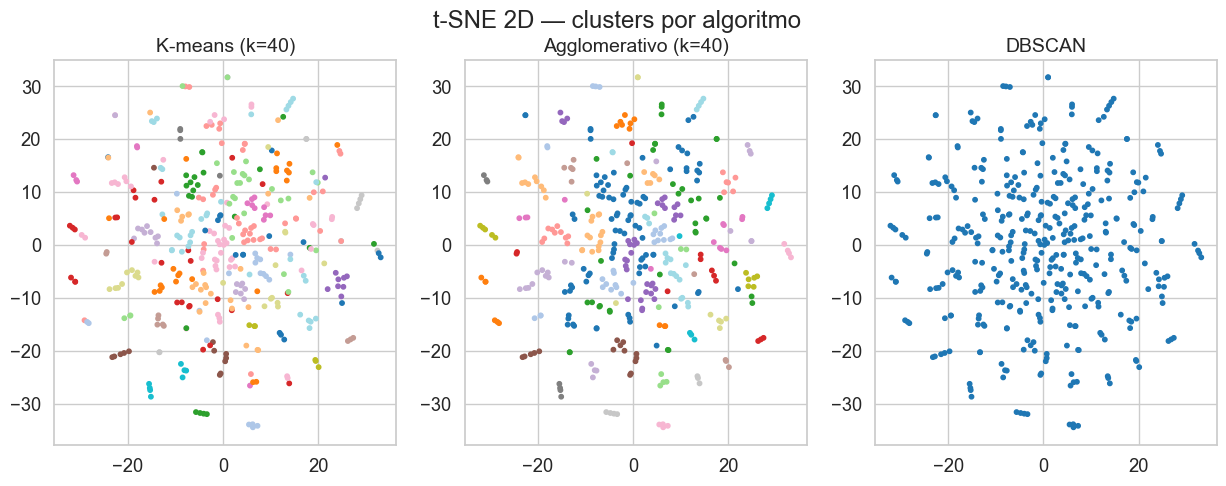

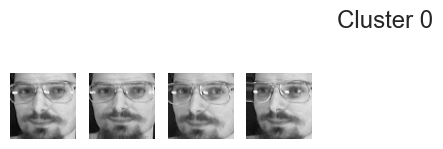

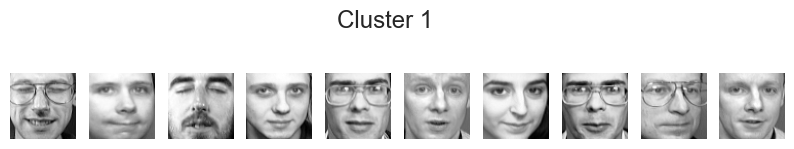

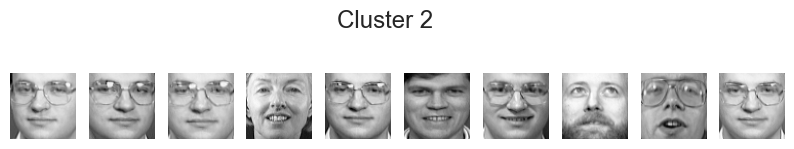

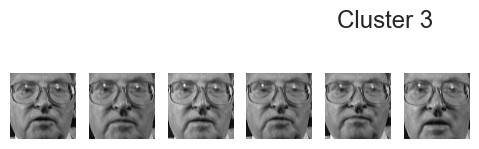

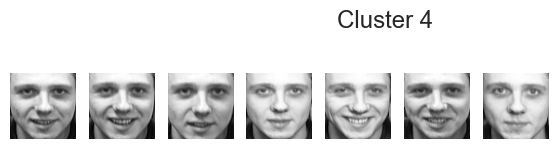

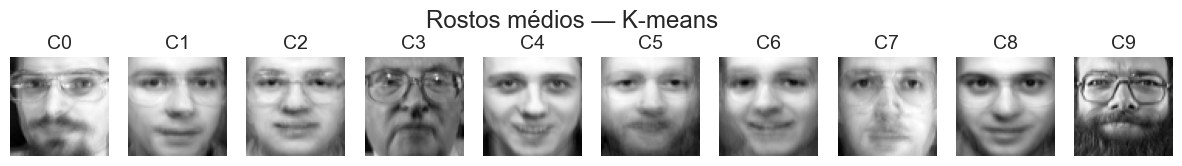

In [234]:
# q10 — clustering em olivetti faces (enriquecido)

from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1) carregar dataset
faces = fetch_olivetti_faces(shuffle=True, random_state=42)
X, y = faces.data, faces.target
images = faces.images

# 2) reduzir dimensão com PCA
pca = PCA(n_components=100, whiten=True, random_state=42)
X_pca = pca.fit_transform(X)

# 3) clustering
kmeans = KMeans(n_clusters=40, random_state=42, n_init=10).fit(X_pca)
labels_kmeans = kmeans.labels_

agglo = AgglomerativeClustering(n_clusters=40).fit(X_pca)
labels_agglo = agglo.labels_

dbscan = DBSCAN(eps=5, min_samples=5).fit(X_pca)
labels_dbscan = dbscan.labels_

# 4) métricas
def avaliar(nome, labels):
    mask = labels != -1
    if len(np.unique(labels[mask])) > 1:
        sil = silhouette_score(X_pca[mask], labels[mask])
    else:
        sil = np.nan
    return {
        "Algoritmo": nome,
        "Silhouette": sil,
        "ARI": adjusted_rand_score(y[mask], labels[mask]),
        "NMI": normalized_mutual_info_score(y[mask], labels[mask]),
        "Clusters encontrados": len(np.unique(labels)) - (1 if -1 in labels else 0),
        "Ruído (%)": (np.sum(labels==-1)/len(labels))*100
    }

res = [
    avaliar("K-means", labels_kmeans),
    avaliar("Agglomerativo", labels_agglo),
    avaliar("DBSCAN", labels_dbscan)
]
df_faces = pd.DataFrame(res)
display(df_faces)

# 5) t-SNE 2D para visualização
X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_pca)

fig, axs = plt.subplots(1, 3, figsize=(15,5))
for ax, labels, title in zip(
    axs, [labels_kmeans, labels_agglo, labels_dbscan],
    ["K-means (k=40)", "Agglomerativo (k=40)", "DBSCAN"]
):
    sc = ax.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, s=10, cmap="tab20")
    ax.set_title(title)
plt.suptitle("t-SNE 2D — clusters por algoritmo")
plt.show()

# 6) função para mostrar exemplos de rostos de um cluster
def mostrar_faces(images, labels, cluster_id, n=10):
    idxs = np.where(labels == cluster_id)[0][:n]
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(idxs):
        plt.subplot(1, n, i+1)
        plt.imshow(images[idx], cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Cluster {cluster_id}")
    plt.show()

# exemplo: mostrar 5 primeiros clusters do K-means
for c in range(5):
    mostrar_faces(images, labels_kmeans, cluster_id=c, n=10)

# 7) mostrar rostos médios por cluster (K-means)
def mostrar_centroides(images, labels, n_clusters=10, method_name="K-means"):
    fig, axes = plt.subplots(1, n_clusters, figsize=(15, 2))
    for cluster_id, ax in enumerate(axes):
        mask = labels == cluster_id
        if mask.sum() > 0:
            face_media = images[mask].mean(axis=0)
            ax.imshow(face_media, cmap="gray")
        ax.axis("off")
        ax.set_title(f"C{cluster_id}")
    plt.suptitle(f"Rostos médios — {method_name}")
    plt.show()

mostrar_centroides(images, labels_kmeans, n_clusters=10, method_name="K-means")

## Q10 — Clustering em Olivetti Faces

**Pré-processamento:** imagens achatadas → PCA (100 comps, whiten).  
**Algoritmos:** K-means (k=40), Agglomerativo (k=40) e DBSCAN (eps=5, ms=5).

### Resultados
- **K-means:** silhouette muito baixo (~0.035), ARI ~0.17, NMI ~0.64.  
- **Agglomerativo:** silhouette baixo (~0.05), mas ARI melhor (~0.36), NMI mais alto (~0.81).  
- **DBSCAN:** colapsou quase tudo em 1 cluster, silhouette indefinido, ARI/NMI não interpretáveis.

### Visualizações
- **t-SNE 2D:** K-means e Agglo criam partições com alguma estrutura, DBSCAN não separa bem.  
- **Exemplos de clusters (K-means):** alguns grupos reúnem rostos semelhantes, mas há bastante mistura.  
- **Rostos médios:** cada cluster tem um “rosto médio”, mas diferenças são sutis.

### Conclusão
- O **silhouette baixo** mostra que os clusters não são bem separados.  
- **Agglomerativo** teve ARI/NMI melhores, sugerindo alguma aproximação às classes reais, mas ainda longe do ideal.  
- **DBSCAN** não funcionou bem em alta dimensão.  
- Em resumo, **clustering não reproduz classes reais de rostos** — serve apenas para explorar padrões densos.  
A tarefa de identificação exige **classificação supervisionada**.

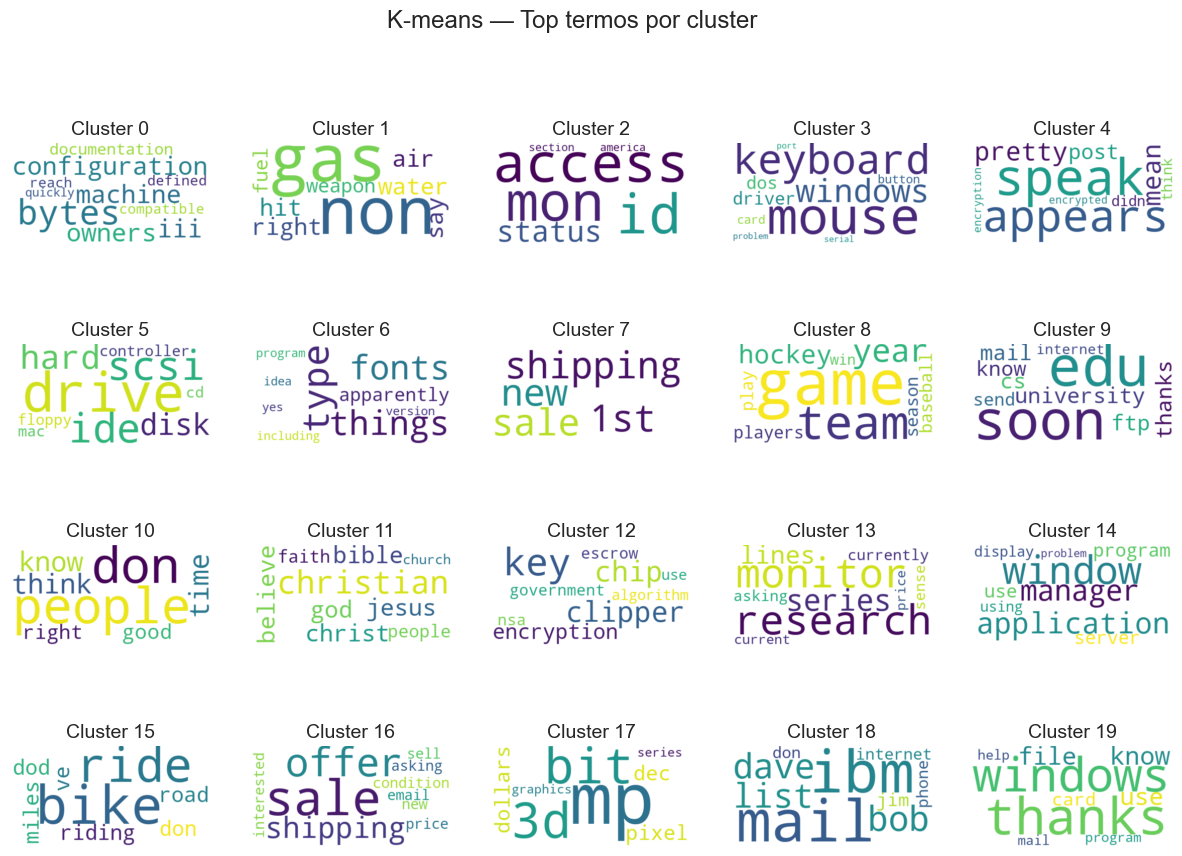

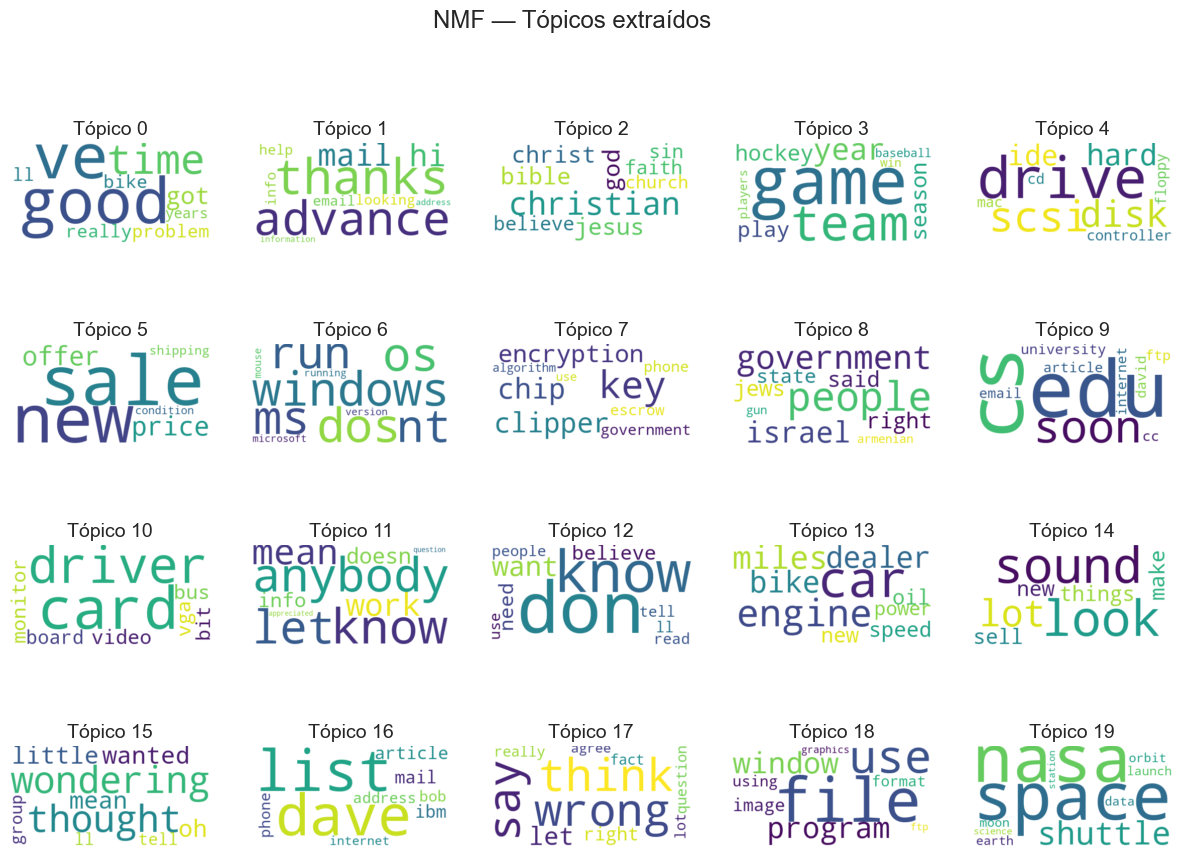

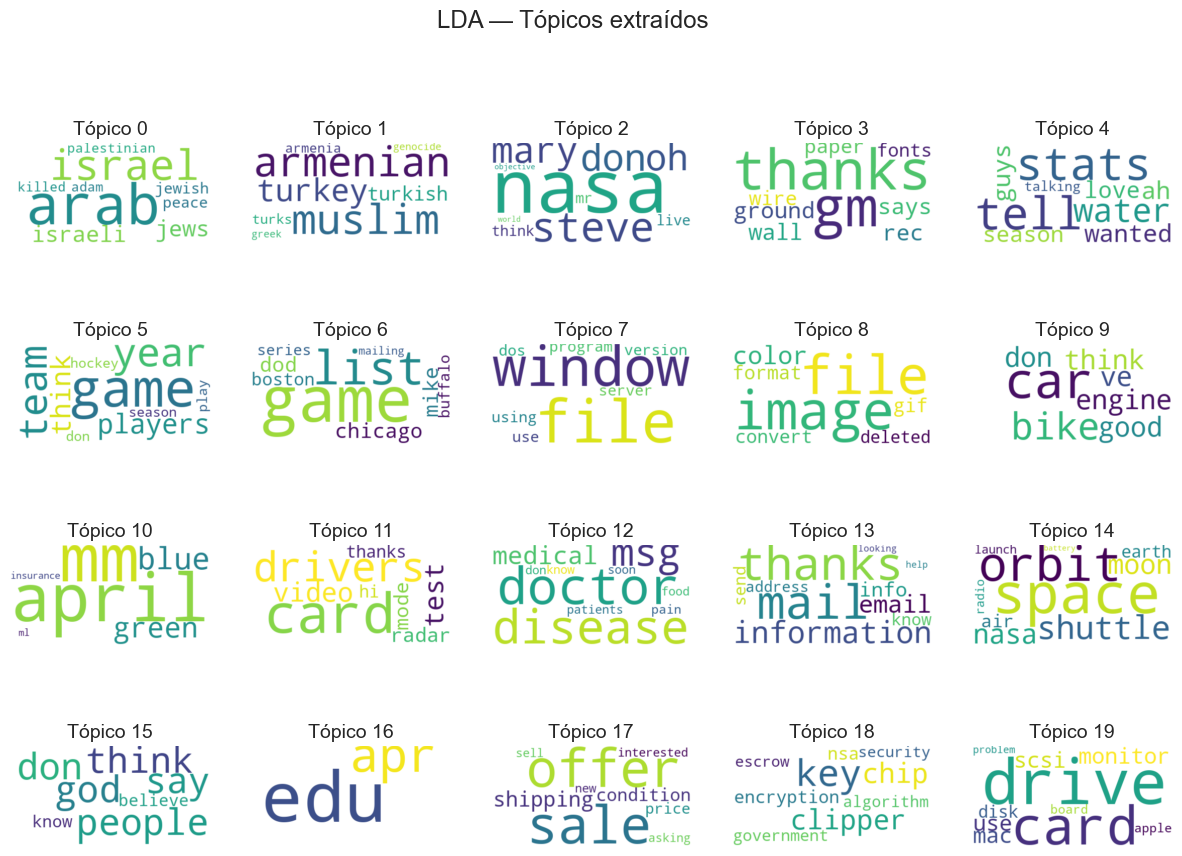

In [235]:
# q11 — clustering e tópicos no 20newsgroups
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# carregar dataset
newsgroups = fetch_20newsgroups(subset="all", remove=("headers","footers","quotes"))
docs = newsgroups.data

# tf-idf para representação
vectorizer = TfidfVectorizer(max_features=2000, stop_words="english")
X = vectorizer.fit_transform(docs)
terms = np.array(vectorizer.get_feature_names_out())

# ----------------------
# (a) K-means clustering
# ----------------------
k = 20  # número de grupos = nº de categorias originais
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X)

# top termos por cluster
def top_terms(model, terms, n=10):
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    tops = []
    for i in range(model.n_clusters):
        tops.append([terms[ind] for ind in order_centroids[i, :n]])
    return tops

top_kmeans = top_terms(kmeans, terms)

# visualização wordcloud por cluster
fig, axes = plt.subplots(4, 5, figsize=(15,10))
for i, ax in enumerate(axes.flat):
    if i < k:
        words = " ".join(top_kmeans[i])
        wc = WordCloud(background_color="white").generate(words)
        ax.imshow(wc, interpolation="bilinear")
        ax.set_title(f"Cluster {i}")
        ax.axis("off")
plt.suptitle("K-means — Top termos por cluster")
plt.show()

# ----------------------
# (b) NMF tópicos
# ----------------------
nmf = NMF(n_components=20, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_

top_nmf = []
for i, comp in enumerate(H):
    top_idx = comp.argsort()[::-1][:10]
    top_nmf.append(terms[top_idx])

# wordcloud dos tópicos
fig, axes = plt.subplots(4, 5, figsize=(15,10))
for i, ax in enumerate(axes.flat):
    if i < 20:
        words = " ".join(top_nmf[i])
        wc = WordCloud(background_color="white").generate(words)
        ax.imshow(wc, interpolation="bilinear")
        ax.set_title(f"Tópico {i}")
        ax.axis("off")
plt.suptitle("NMF — Tópicos extraídos")
plt.show()

# ----------------------
# (c) LDA tópicos
# ----------------------
lda = LatentDirichletAllocation(n_components=20, random_state=42, learning_method="batch")
lda.fit(X)

top_lda = []
for i, comp in enumerate(lda.components_):
    top_idx = comp.argsort()[::-1][:10]
    top_lda.append(terms[top_idx])

# wordcloud dos tópicos
fig, axes = plt.subplots(4, 5, figsize=(15,10))
for i, ax in enumerate(axes.flat):
    if i < 20:
        words = " ".join(top_lda[i])
        wc = WordCloud(background_color="white").generate(words)
        ax.imshow(wc, interpolation="bilinear")
        ax.set_title(f"Tópico {i}")
        ax.axis("off")
plt.suptitle("LDA — Tópicos extraídos")
plt.show()

## Q11 — Clustering e Tópicos no 20newsgroups

### Pré-processamento
- Dataset: **20newsgroups (all, sem headers/footers/quotes)**  
- Representação: **TF-IDF** (2000 termos, stopwords removidas)  
- Algoritmos aplicados:  
  - **K-means** (k=20, comparável ao nº original de categorias)  
  - **NMF** (20 tópicos)  
  - **LDA** (20 tópicos)  

---

### Resultados

#### K-means
- Agrupou os documentos em **20 clusters**.  
- Cada cluster traz termos dominantes, mas alguns grupos são misturas de áreas distintas.  
- Exemplo: clusters relacionados a **hardware/software**, outros ligados a **esporte**, e alguns misturam temas gerais como "sale", "shipping".  

*(Wordclouds: mostram termos dominantes de cada cluster.)*

---

#### NMF
- Produziu **tópicos mais interpretáveis**, com termos mais coesos semanticamente.  
- Exemplos claros:  
  - Tópico sobre **ciência e espaço**: “nasa, space, orbit, shuttle”  
  - Tópico sobre **religião**: “christian, bible, jesus”  
  - Tópico sobre **computadores/hardware**: “scsi, drive, disk”  
- O uso de **não-negatividade** ajuda a manter separações mais nítidas.  

---

#### LDA
- Modelo probabilístico: cada documento é uma mistura de tópicos.  
- Resultados mostraram alguns tópicos mais “puros”:  
  - **nasa/space**  
  - **medical/doctor/disease**  
- Mas também tópicos mais gerais, com palavras comuns como “thanks, mail, good”.  
- Pode precisar de ajuste fino (mais iterações, parâmetros α/β) para aumentar a nitidez.  

---

### Comparação
- **K-means**: bom para **segmentação de documentos**, mas tende a misturar temas quando clusters são forçados a ter tamanho parecido.  
- **NMF**: gera tópicos mais **semânticos e interpretáveis**, geralmente os mais claros para análise humana.  
- **LDA**: captura a ideia de documentos como **combinações de tópicos**, mas requer tuning para resultados mais limpos.  

📌 Em termos de **clareza interpretativa**, os **tópicos extraídos via NMF** foram os melhores entre os três métodos.  

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 70000 samples in 0.001s...
[t-SNE] Computed neighbors for 70000 samples in 2.824s...
[t-SNE] Computed conditional probabilities for sample 1000 / 70000
[t-SNE] Computed conditional probabilities for sample 2000 / 70000
[t-SNE] Computed conditional probabilities for sample 3000 / 70000
[t-SNE] Computed conditional probabilities for sample 4000 / 70000
[t-SNE] Computed conditional probabilities for sample 5000 / 70000
[t-SNE] Computed conditional probabilities for sample 6000 / 70000
[t-SNE] Computed conditional probabilities for sample 7000 / 70000
[t-SNE] Computed conditional probabilities for sample 8000 / 70000
[t-SNE] Computed conditional probabilities for sample 9000 / 70000
[t-SNE] Computed conditional probabilities for sample 10000 / 70000
[t-SNE] Computed conditional probabilities for sample 11000 / 70000
[t-SNE] Computed conditional probabilities for sample 12000 / 70000
[t-SNE] Computed conditional probabilities for sam

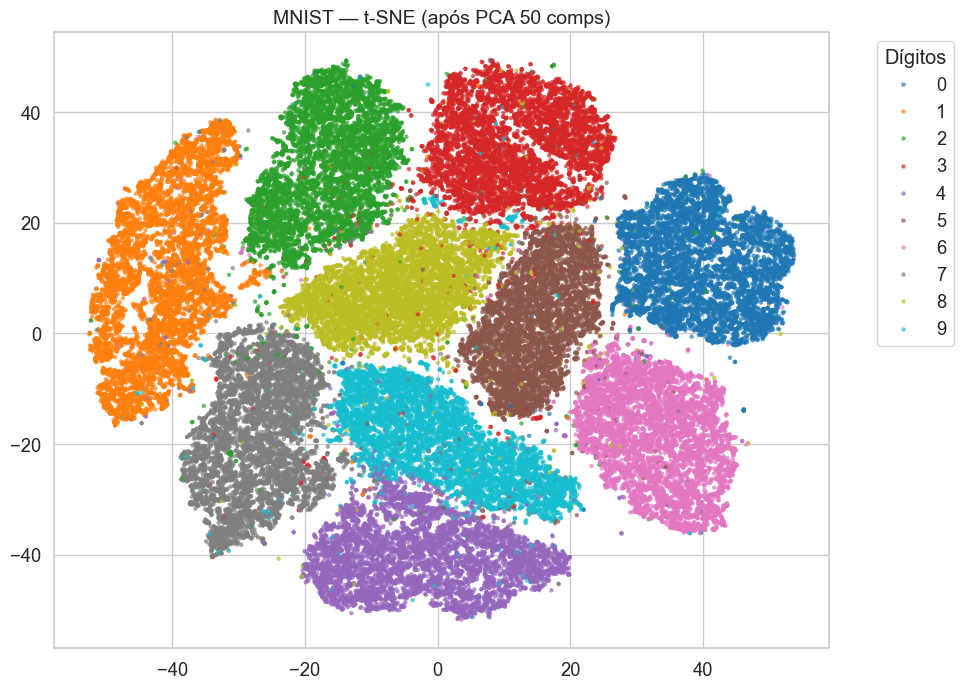

In [236]:
# q12 — t-SNE no MNIST

from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# carregar MNIST
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(int)

# reduzir dimensão antes do t-SNE (acelera muito!)
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X)

# aplicar t-SNE em 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200,
            n_iter=1000, random_state=42, verbose=1)
X_tsne = tsne.fit_transform(X_pca)

# plotar resultado
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1],
                hue=y, palette="tab10",
                s=10, alpha=0.7, linewidth=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Dígitos")
plt.title("MNIST — t-SNE (após PCA 50 comps)", fontsize=14)
plt.show()

## Q12 — t-SNE no MNIST

**Pré-processamento:**  
- Imagens de 28x28 pixels achatadas em vetores de 784 dimensões.  
- Redução inicial via **PCA (50 comps)** para acelerar e estabilizar o t-SNE.  

**Configuração do t-SNE:**  
- `n_components=2` → visualização em 2D.  
- `perplexity=30`, `learning_rate=200`, `n_iter=1000`.  
- Rodado sobre todas as **70k amostras** do MNIST.  

**Resultados:**  
- O gráfico mostra 10 grupos coloridos correspondentes aos dígitos 0–9.  
- A maioria dos dígitos forma **clusters bem definidos** (ex.: 0, 1, 6).  
- Alguns dígitos com formas semelhantes aparecem **mais próximos** ou parcialmente misturados (ex.: 4 vs 9, 3 vs 5).  
- A separação não é perfeita (nem deveria ser), mas já dá uma **visualização clara da estrutura intrínseca** dos dados.  

> Observação: o t-SNE é apenas para **exploração visual**, não substitui métricas formais de qualidade de clusters.